In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from cplAE_MET.models.augmentations import undo_radial_correction, do_radial_correction
from cplAE_MET.preproc.data_proc_M import set_paths, get_file_apendix, get_cell_ids_of_abnormal_images

# This is used to be able to run the notebook both remote and locally
Allen_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/git_workspace/cplAE_MET/data/"
remote_dir = "/Users/fahimehb/Documents/git-workspace/cplAE_MET/data/"

/allen/programs/celltypes/workgroups/rnaseqanalysis/Fahimehb/miniconda3/envs/cplmet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading the m_anno file and arbor densities

In [2]:
pth = set_paths(config_file="config_preproc.toml")
m_anno_path = pth['m_anno']
hist2d_120x4_path = pth["hist2d_120x4"]

### Removing all the cells that have "few" nonzero pixels in their arbor densities
There are some cells that have for example less than 5 pixels with nonzero values. These cells should be removed.

In [3]:
################## Reading m_anno and finding cells with few nonzero pixels
ids = pd.read_csv(pth['specimen_ids'])
specimen_ids = ids['specimen_id'].tolist()
m_anno = pd.read_csv(m_anno_path) #This is used for soma depth and class type
ab_spec_id = get_cell_ids_of_abnormal_images(specimen_ids, hist2d_120x4_path, m_anno,  min_nonzero_pixels=5)
print(len(ab_spec_id), "cells will be dropped because of the few non zero pixels")
drop_spec_id = ab_spec_id

6570it [01:22, 79.56it/s] 

31 cells will be dropped because of the few non zero pixels


### Explaining few function that are applied to the arbor densities  
In the next step that we prepare the M data for all the cells (putting nans for the cells that don't have M data available), we use couple of functions that we explain here.
Olga has originally implemented a correction for the arbor densities. She has divided the values along the x axis with pi*(r2 ^ 2 - r1 ^ 2) so basically getting the arbor densities is like that. If we dont do this, then we call them arbor mass. We decided to remove that correction and then normalize the mass sum to a number for which the density sum again adds up to something close to 100 (becasue around this regime our model was working fine). This is done becasue we think that instead of normalizing arbor density, one should normalize the mass

<AxesSubplot:>

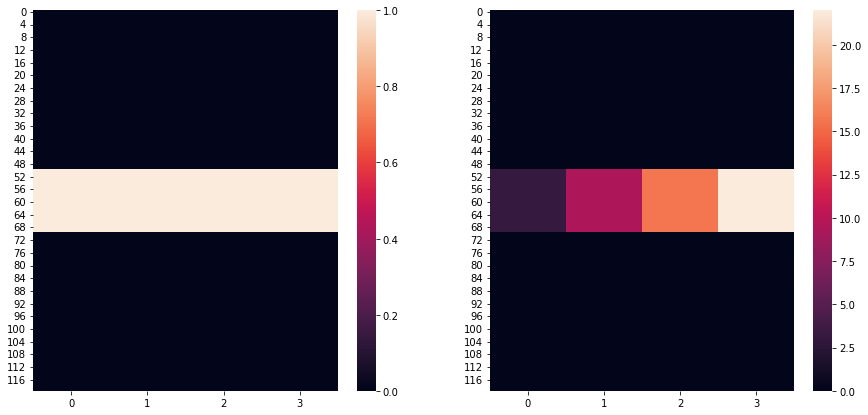

In [4]:
# Lets assume that we have a simple image like this
image = np.zeros((120, 4, 2))
image[50:70, :, 0] =  1

# When we remove the radial correction that Olga implemented
raw_image = undo_radial_correction(image)

f, ax = plt.subplots(1, 2, figsize=(15,7))
sns.heatmap(np.squeeze((image))[:,:,0], cbar=True, ax=ax[0])
sns.heatmap(np.squeeze((raw_image))[:,:,0], cbar=True, ax=ax[1])

<AxesSubplot:>

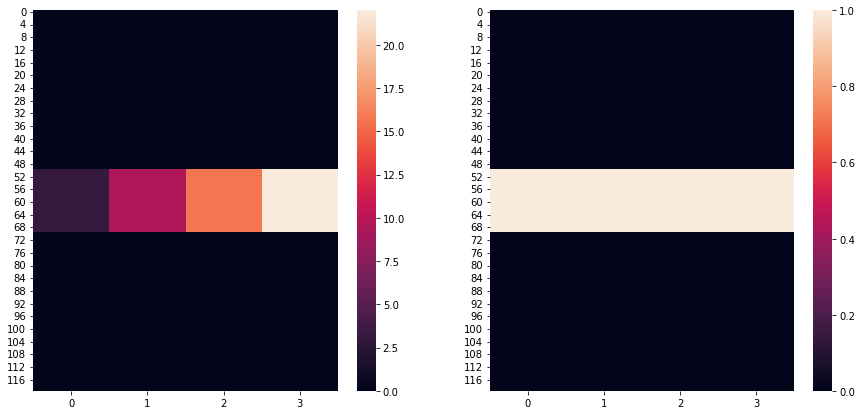

In [5]:
# Now lets assume that we have done the normalization of the mass and we want to redo the radial correction
image_again = do_radial_correction(raw_image)

f, ax = plt.subplots(1, 2, figsize=(15,7))
sns.heatmap(np.squeeze((raw_image))[:,:,0], cbar=True, ax=ax[0])
sns.heatmap(np.squeeze((image_again))[:,:,0], cbar=True, ax=ax[1])

### Arbor densities for all the cells 
for those that we dont have M, we put nan"

In [6]:
print("...................................................")
print("Generating image for all spec_ids, for those that we dont have M, we put nan")
hist_shape = (1, 120, 4, 1)
im_shape = (1, 120, 4, 4)
im = np.zeros((ids.shape[0], 120, 4, 4), dtype=float)
soma_depth = np.zeros((ids.shape[0],))
c = 0
for i, spec_id in tqdm(enumerate(ids['specimen_id'])):
    if spec_id in drop_spec_id:
        im[i, ...] = np.full(im_shape, np.nan)
        soma_depth[i] = np.nan
    else:
        if spec_id in m_anno['specimen_id'].to_list():
            exc_or_inh = m_anno[m_anno['specimen_id'] == spec_id]['class'].values[0]
            app = get_file_apendix(exc_or_inh)
            if os.path.isfile(hist2d_120x4_path + f'/hist2d_120x4_{app[0]}_{spec_id}.csv'):
                c += 1
                im0 = pd.read_csv(hist2d_120x4_path + f'/hist2d_120x4_{app[0]}_{spec_id}.csv', header=None).values
                im1 = pd.read_csv(hist2d_120x4_path + f'/hist2d_120x4_{app[1]}_{spec_id}.csv', header=None).values

                #convert arbor density to arbor mass
                mass0 = undo_radial_correction(im0)
                mass1 = undo_radial_correction(im1)

                # Normalize so that the mass sum is 350, this way when we redo the radial correction in the next step, 
                # arbor density sums to around 100 ... which is a good regime for our model and we would like to stay in that regime
                mass0 = mass0 * 350 / np.sum(mass0)
                mass1 = mass1 * 350 / np.sum(mass1)

                #compute the arbor density from the arbor mass again
                im0 = do_radial_correction(mass0)
                im1 = do_radial_correction(mass1)

                if exc_or_inh == "inh":
                    im[i, :, :, 0:2] = (np.concatenate([im0.reshape(hist_shape), im1.reshape(hist_shape)], axis=3))
                else:
                    im[i, :, :, 2:] = (np.concatenate([im0.reshape(hist_shape), im1.reshape(hist_shape)], axis=3))

                soma_depth[i] = np.squeeze(m_anno.loc[m_anno['specimen_id'] == spec_id]['soma_depth'].values)
            else:
                im[i, ...] = np.full(im_shape, np.nan)
                soma_depth[i] = np.nan
        else:
            im[i, ...] = np.full(im_shape, np.nan)
            soma_depth[i] = np.nan

print("so far in total", c, "cells have m data available")

...................................................
Generating image for all spec_ids, for those that we dont have M, we put nan


6570it [00:15, 425.64it/s] 

so far in total 1575 cells have m data available


### Check arbor density sum for exc and inh cells

Previously we were normalizing the arbor density to sum to 100, however now we nromalize the mass to become 350 and instead arbor densities should sum to around 100 but not exactly 100.

In [7]:
df = pd.DataFrame()
df['specimen_id'] = ids['specimen_id']
df = df.merge(m_anno, on="specimen_id", how="left").drop(columns=["Unnamed: 0"])
df['mask_exc'] = False
df['mask_inh'] = False
df.loc[df['class']=="exc", 'mask_exc'] = True
df.loc[df['class']=="inh", 'mask_inh'] = True
df

,specimen_id,soma_depth,class,mask_exc,mask_inh
0,823231829,NaN,NaN,False,False
1,893406540,NaN,NaN,False,False
2,896877084,NaN,NaN,False,False
3,912008949,NaN,NaN,False,False
4,921685533,0.16624,exc,True,False
...,...,...,...,...,...
6565,912896324,0.85001,exc,True,False
6566,927889009,0.89556,exc,True,False
6567,601790961,0.62492,inh,False,True
6568,639818525,0.47378,inh,False,True


In [8]:
exc_M_im = im[df['mask_exc'].to_list()]
inh_M_im = im[df['mask_inh'].to_list()]

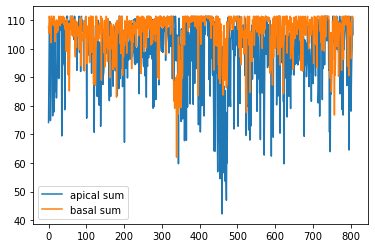

In [9]:
# For exc cells
plt.plot(exc_M_im.sum(axis=(1,2))[:, 2], label="apical sum")
plt.plot(exc_M_im.sum(axis=(1,2))[:, 3], label="basal sum")
plt.legend()

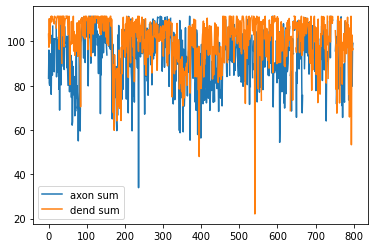

In [10]:
# For inh cells
plt.plot(inh_M_im.sum(axis=(1,2))[:, 0], label="axon sum")
plt.plot(inh_M_im.sum(axis=(1,2))[:, 1], label="dend sum")
plt.legend()

Now M data is ready to be integrated togther in a mat file for T_ME model